## 准备工作

1. 导入所需包

In [1]:
import os
import random
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import time
import tensorflow as tf
import tenseal as ts # pip install tenseal
from tqdm import tqdm


2023-11-28 11:21:30.420959: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-28 11:21:30.423702: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-28 11:21:30.457323: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-28 11:21:30.457350: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-28 11:21:30.458381: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

2. 设置参数

In [2]:
batch_size = 5 # 每次输入图片数量
test_times = 5 # 实验次数
image_dir = './data/original' # 图像存储目录
encrypted_dir = './data/encrypted' # 图像加密后存放的文件目录

# 使用GPU
physical_devices = tf.config.list_physical_devices()
print(physical_devices)
print("Num GPUs Available: ", len(physical_devices)-1)
if len(physical_devices) > 1:
    tf.config.experimental.set_memory_growth(physical_devices[1], True)



[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Num GPUs Available:  0


2023-11-28 11:21:31.792054: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


3. 查看数据

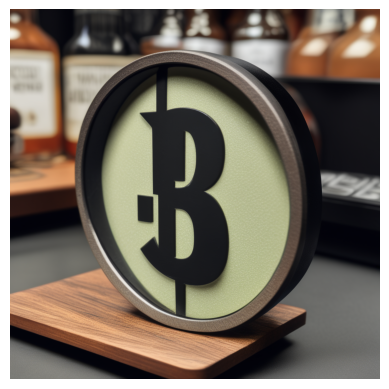

In [3]:
# 获取图像文件列表
image_list = [os.path.join(image_dir, image) for image in os.listdir(image_dir) if image.endswith('.png')]

# 随机选择图像
random_images = random.sample(image_list, batch_size)

# 读取图像
img = mpimg.imread(random_images[1])

# 显示图像
plt.imshow(img)
plt.axis('off')
plt.show()


## 加密

In [4]:
start_time = time.perf_counter()

# 将图像转换为张量
images = [tf.io.read_file(image) for image in random_images]
images = [tf.image.decode_png(image, channels=3) for image in images] # decode_jpeg/png/...
images = [tf.image.resize(image, [64, 64]) for image in images]
images = [tf.image.convert_image_dtype(image, tf.float32) for image in images] # 将图像数据归一化到 [0, 1] 范围

# 设置TenSEAL上下文, 算法可选: BFV/CKKS
# CKKS
context = ts.context(ts.SCHEME_TYPE.CKKS, poly_modulus_degree=8192*4, coeff_mod_bit_sizes=[60, 40, 40, 60])
context.global_scale = 2**40
context.generate_galois_keys()

# 加密图像
encrypted_images = []
for image in tqdm(images, desc="Encrypting images", unit="image"):
    encrypted_vector = ts.ckks_vector(context, image.numpy().flatten().tolist())
    encrypted_images.append(encrypted_vector)
    
# 将加密的图像序列化并保存到文件中
pbar = tqdm(total=len(encrypted_images), desc="Saving encrypted images", unit="image") # 创建进度条

for i, encrypted_image in enumerate(encrypted_images):
    with open("{}/encrypted_image_{}.pkl".format(encrypted_dir,i), "wb") as f:
        f.write(encrypted_image.serialize())
        print(encrypted_image.size())
    
    pbar.update(1)

pbar.close()

# 计算加密时间
encryption_time = (time.perf_counter() - start_time) # to microseconds: * 1e6
average_encryption_time = encryption_time / batch_size

Saving encrypted images: 100%|██████████| 5/5 [00:00<00:00, 80.00image/s]

12288
12288
12288
12288
12288


## 查询

因为是同态加密，所以查询等操作直接在加密态上进行而无需解密，这里的操作是"查询后比较匹配"。

In [5]:
query_image_path = random_images[3] # 原图匹配
# query_image_path = '/home/sysu/.kun/study/SSaPP/hw2/python/tenseal_test/data/test/image_test.png' # 不相干图匹配

# 查询图片加密
query_image = tf.io.read_file(query_image_path) 
query_image = tf.image.decode_png(query_image, channels=3)
query_image = tf.image.resize(query_image, [64, 64])
query_image = tf.image.convert_image_dtype(query_image, tf.float32)
encrypted_query_image = ts.ckks_vector(context, query_image.numpy().flatten().tolist())


start_time = time.perf_counter()

similarity_scores = []
pbar = tqdm(total=len(encrypted_images), desc="Querying images", unit="image")
for i in range(len(encrypted_images)):
    with open("{}/encrypted_image_{}.pkl".format(encrypted_dir,i), "rb") as f:
        encrypted_image = ts.ckks_vector_from(context, f.read())
        print(encrypted_image.size())
        # 通过余弦相似度匹配, 存储图像时已经是归一化, 无需除以模长
        
        dot_image = encrypted_query_image.dot(encrypted_image)
        similarity_score = dot_image.decrypt()[0]
        similarity_scores.append(similarity_score)
        pbar.update(1)
pbar.close()

# 计算匹配时间
query_time = (time.perf_counter() - start_time) # * 1e6
average_query_time = query_time / batch_size

# 归一化 similarity_scores
max_score = max(similarity_scores)
min_score = min(similarity_scores)
normalized_similarity_scores = [(score - min_score) / (max_score - min_score) for score in similarity_scores]

# 匹配分数
for i, score in enumerate(normalized_similarity_scores):
    print("Normalized Similarity score with encrypted_image_{}.pkl: {:.4f}".format(i, score))



Querying images:  20%|██        | 1/5 [00:00<00:00,  4.73image/s]

12288
12288


Querying images:  40%|████      | 2/5 [00:00<00:00,  4.77image/s]

12288


Querying images:  60%|██████    | 3/5 [00:00<00:00,  4.79image/s]

12288


Querying images:  80%|████████  | 4/5 [00:00<00:00,  4.81image/s]

12288


Querying images: 100%|██████████| 5/5 [00:01<00:00,  4.80image/s]

Normalized Similarity score with encrypted_image_0.pkl: 0.3238
Normalized Similarity score with encrypted_image_1.pkl: 0.1903
Normalized Similarity score with encrypted_image_2.pkl: 0.0000
Normalized Similarity score with encrypted_image_3.pkl: 1.0000
Normalized Similarity score with encrypted_image_4.pkl: 0.2774


查看匹配结果

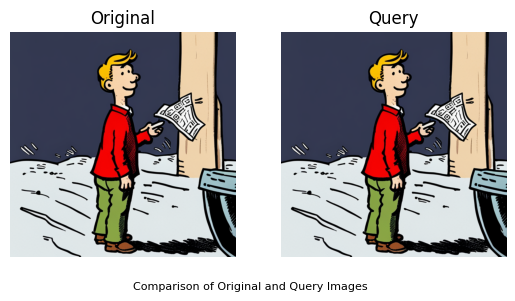

In [6]:
max_index = similarity_scores.index(max(similarity_scores))

# 匹配度最高的加密文件的原始图像
plt.subplot(1, 2, 1)
img1 = mpimg.imread(random_images[max_index])
plt.imshow(img1)
plt.axis('off')
plt.title('Original')

plt.subplot(1, 2, 2)
img2 = mpimg.imread(query_image_path)
plt.imshow(img2)
plt.axis('off')
plt.title('Query')

# 添加整个图的标题
# plt.suptitle('Comparison of Original Image Matched and Query Image')
fig = plt.gcf()
fig_size = fig.get_size_inches()
fig.text(0.5, 0.2, 'Comparison of Original and Query Images', ha='center', va='center', fontsize=8)

plt.show()

## 比较算法效率

In [7]:
# 算法执行效率
print("Average Encryption Time: {:.4f} seconds / image".format(average_encryption_time))
print("Average Query Time: {:.4f} seconds / image".format(average_query_time))

Average Encryption Time: 0.2580 seconds / image
Average Query Time: 0.2088 seconds / image
